In [1]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

class NumDocsPriorFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, k_max=5, alpha=1.0, use_time=True, min_group_count=50):
        self.k_max = k_max
        self.alpha = alpha
        self.use_time = use_time
        self.min_group_count = min_group_count
        self.global_probs_ = None
        self.task_probs_ = None
        self.task_counts_ = None
        self.task_time_probs_ = None
        self.task_time_counts_ = None

    def _ensure_datetime(self, X):
        if 'appointment_datetime' in X.columns and X['appointment_datetime'].notna().any():
            dt = pd.to_datetime(X['appointment_datetime'], errors='coerce')
        else:
            date = pd.to_datetime(X.get('appointment_date'), errors='coerce')
            time = X.get('appointment_time')
            if time is None:
                # no time provided; default to midnight
                dt = date
            else:
                # ensure string, fill missing times with 00:00:00
                time_str = time.astype(str).where(time.notna(), '00:00:00')
                dt = pd.to_datetime(date.astype(str) + ' ' + time_str, errors='coerce')
        return dt

    def _prep_time(self, X):
        X = X.copy()
        dt = self._ensure_datetime(X)
        dow = dt.dt.dayofweek.astype('Int64')  # nullable int
        hour = dt.dt.hour.astype('Int64')
        X['dow'] = dow.fillna(-1)              # mark missing as -1
        X['hour_bin'] = (hour // 2).astype('Int64').fillna(-1)
        return X

    def _clip_k(self, s):
        s = s.astype(int)
        return s.where(s <= self.k_max, self.k_max + 1)

    def _probs_from_counts(self, counts_row):
        total = counts_row.sum()
        return (counts_row + self.alpha) / (total + self.alpha * len(counts_row)) if total > 0 else counts_row * 0.0

    def _to_feature_row(self, probs):
        exp = float(np.dot(probs.index, probs.values))
        mode = int(probs.idxmax())
        feat = {f'p_numdocs_{int(k) if k <= self.k_max else f"ge_{self.k_max+1}"}': float(probs[k]) for k in probs.index}
        feat['numdocs_expected'] = exp
        feat['numdocs_mode'] = mode
        return feat

    def fit(self, X, y=None):
        needed = ['task_id', 'num_documents']
        missing = [c for c in needed if c not in X.columns]
        if missing:
            raise ValueError(f"Missing columns for fit: {missing}")

        df = X[['task_id', 'num_documents']].copy()
        if self.use_time:
            df_time = X[['task_id']].copy()
            df_time['appointment_date'] = X.get('appointment_date', pd.NaT)
            df_time['appointment_time'] = X.get('appointment_time', pd.NaT)
            df_time['appointment_datetime'] = X.get('appointment_datetime', pd.NaT)
            df_time = pd.concat([df_time, X.filter(items=['appointment_datetime'], axis=1)], axis=1)
            df = pd.concat([df, df_time.drop(columns=['task_id'])], axis=1)
            df = self._prep_time(df)

        df['k'] = self._clip_k(df['num_documents'])

        global_counts = df['k'].value_counts().reindex(range(self.k_max+2), fill_value=0).sort_index()
        self.global_probs_ = self._probs_from_counts(global_counts)

        task_counts = (
            df.groupby('task_id')['k'].value_counts()
              .unstack(fill_value=0)
              .reindex(columns=range(self.k_max+2), fill_value=0)
              .sort_index(axis=1)
        )
        self.task_counts_ = task_counts
        self.task_probs_ = task_counts.apply(self._probs_from_counts, axis=1)

        if self.use_time:
            g = df.groupby(['task_id', 'dow', 'hour_bin'])['k'].value_counts()
            task_time_counts = (
                g.unstack(fill_value=0)
                 .reindex(columns=range(self.k_max+2), fill_value=0)
                 .sort_index(axis=1)
            )
            self.task_time_counts_ = task_time_counts

            rows = []
            for idx, row in task_time_counts.iterrows():
                count = row.sum()
                task = idx[0]
                base = self._probs_from_counts(row)
                if count >= self.min_group_count:
                    lam_t = 0.7
                else:
                    lam_t = (count / max(1, self.min_group_count)) * 0.7
                task_prob = self.task_probs_.loc[task] if task in self.task_probs_.index else self.global_probs_
                backoff = 0.3
                lam_g = max(0.0, 1.0 - lam_t - backoff)
                smoothed = lam_t * base + backoff * task_prob + lam_g * self.global_probs_
                smoothed.index = base.index
                rows.append((idx, smoothed))
            self.task_time_probs_ = pd.DataFrame({idx: s for idx, s in rows}).T

        return self

    def transform(self, X):
        Z = X[['task_id']].copy()
        if self.use_time:
            Z['appointment_date'] = X.get('appointment_date', pd.NaT)
            Z['appointment_time'] = X.get('appointment_time', pd.NaT)
            Z['appointment_datetime'] = X.get('appointment_datetime', pd.NaT)
            Z = self._prep_time(Z)

        feat_rows = []
        for i, row in Z.iterrows():
            task = row['task_id']
            if self.use_time:
                d = int(row['dow'])
                h = int(row['hour_bin'])
                key = (row['task_id'], d, h)
                if self.task_time_probs_ is not None and key in self.task_time_probs_.index:
                    probs = self.task_time_probs_.loc[key]
                elif task in self.task_probs_.index:
                    probs = self.task_probs_.loc[task]
                else:
                    probs = self.global_probs_
            else:
                probs = self.task_probs_.loc[task] if task in self.task_probs_.index else self.global_probs_
            feat_rows.append(self._to_feature_row(probs))

        return pd.DataFrame(feat_rows, index=Z.index)

In [3]:
df_preprocessed = pd.read_csv('data/processed/bookings_PreProcessed.csv')
df_preprocessed.head()

,appointment_date,appointment_time,task_id,num_documents,employees_on_duty,duration_log,hour_sin,hour_cos,dow_0,dow_1,...,task_TASK-010,task_TASK-011,task_TASK-012,task_TASK-013,task_TASK-014,task_TASK-015,task_TASK-016,task_TASK-017,task_TASK-018,task_TASK-019
0,2021-01-01,09:03,TASK-002,0,-1.391228,3.637586,0.707107,-0.707107,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2021-01-01,09:12,TASK-001,1,-1.391228,4.110874,0.707107,-0.707107,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2021-01-01,09:36,TASK-002,1,-1.391228,4.060443,0.707107,-0.707107,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2021-01-01,09:45,TASK-001,1,-1.391228,3.988984,0.707107,-0.707107,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2021-01-01,10:12,TASK-002,1,-1.391228,4.488636,0.500000,-0.866025,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# # Create a readable task_id from one-hot task columns
# task_cols = [c for c in df_preprocessed.columns if c.startswith('task_')]
# df_preprocessed['task_id'] = df_preprocessed[task_cols].idxmax(axis=1).str.replace('task_', '')

# # If any rows can have no task selected, uncomment to filter to valid rows
# # df_preprocessed = df_preprocessed[df_preprocessed[task_cols].sum(axis=1) == 1].copy()

In [5]:
# # Count appointments for each task
# task_counts = df_preprocessed[task_cols].sum().sort_values(ascending=False)

# # Create task names (remove 'task_' prefix)
# task_names = [col.replace('task_', '') for col in task_counts.index]

# # Create the visualization
# plt.figure(figsize=(15, 8))
# bars = plt.bar(range(len(task_counts)), task_counts.values, color='skyblue', edgecolor='navy', alpha=0.7)

# # Customize the plot
# plt.title('Number of Appointments by Task', fontsize=16, fontweight='bold', pad=20)
# plt.xlabel('Task ID', fontsize=12)
# plt.ylabel('Number of Appointments', fontsize=12)

# # Set x-axis labels
# plt.xticks(range(len(task_counts)), task_names, rotation=45, ha='right')

# # Add value labels on bars
# for i, (bar, count) in enumerate(zip(bars, task_counts.values)):
#     plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(task_counts.values)*0.01, 
#              f'{int(count):,}', ha='center', va='bottom', fontweight='bold')

# # Add grid for better readability
# plt.grid(axis='y', alpha=0.3)

# # Adjust layout
# plt.tight_layout()
# plt.show()

# # Print summary statistics
# print(f"\nSummary Statistics:")
# print(f"Total number of appointments: {task_counts.sum():,}")
# print(f"Number of tasks: {len(task_counts)}")
# print(f"Average appointments per task: {task_counts.mean():,.1f}")
# print(f"Most popular task: {task_names[0]} with {task_counts.iloc[0]:,} appointments")
# print(f"Least popular task: {task_names[-1]} with {task_counts.iloc[-1]:,} appointments")

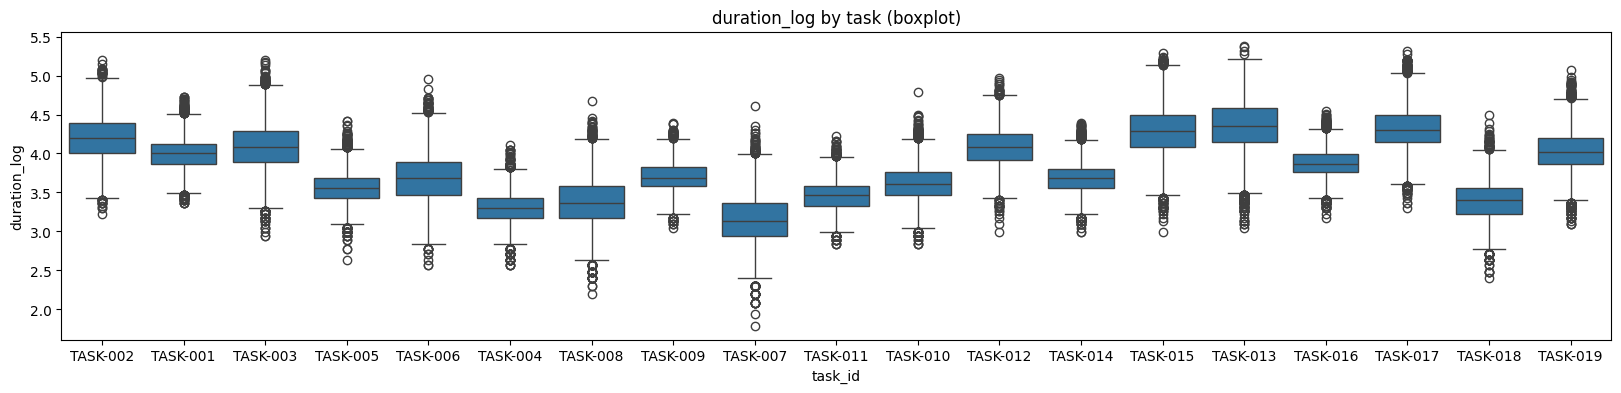

In [6]:
# Visualize duration_log by task for TASK-010 vs TASK-011
subset = df_preprocessed.copy()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20,4))
sns.boxplot(data=subset, x='task_id', y='duration_log')
plt.title('duration_log by task (boxplot)')
plt.show()

In [7]:
# Ensure datetime column exists
df_preprocessed = df_preprocessed.copy()
if 'appointment_datetime' not in df_preprocessed.columns:
    date = pd.to_datetime(df_preprocessed['appointment_date'], errors='coerce')
    if 'appointment_time' in df_preprocessed.columns:
        time_str = df_preprocessed['appointment_time'].astype(str).where(
            df_preprocessed['appointment_time'].notna(), '00:00:00'
        )
        df_preprocessed['appointment_datetime'] = pd.to_datetime(
            date.astype(str) + ' ' + time_str, errors='coerce'
        )
    else:
        df_preprocessed['appointment_datetime'] = date

# Sort by time and split last 20% as test
df_sorted = df_preprocessed.sort_values('appointment_datetime')
cut_idx = int(np.floor(0.8 * len(df_sorted)))

train_df = df_sorted.iloc[:cut_idx].copy()
test_df  = df_sorted.iloc[cut_idx:].copy()

# # Ensure task_id exists
# if 'task_id' not in df_preprocessed.columns:
#     task_cols = [c for c in df_preprocessed.columns if c.startswith('task_')]
#     df_preprocessed['task_id'] = df_preprocessed[task_cols].idxmax(axis=1).str.replace('task_', '')
#     # Optional: enforce exactly one active task
#     # df_preprocessed = df_preprocessed[df_preprocessed[task_cols].sum(axis=1) == 1].copy()

# # Drop too-rare classes for 80/20 stratification (need >= 5 to guarantee ≥1 in test)
# test_size = 0.2
# min_count = int(np.ceil(1 / test_size))
# counts = df_preprocessed['task_id'].value_counts()
# keep_classes = counts[counts >= min_count].index
# df_strata = df_preprocessed[df_preprocessed['task_id'].isin(keep_classes)].copy()

# # Stratified split
# train_df, test_df = train_test_split(
#     df_strata,
#     test_size=test_size,
#     random_state=42,
#     stratify=df_strata['task_id']
# )

# Sanity check: distributions should match closely
print("Train task dist (top):")
print(train_df['task_id'].value_counts(normalize=True).head())
print("\nTest task dist (top):")
print(test_df['task_id'].value_counts(normalize=True).head())

Train task dist (top):
task_id
TASK-005    0.082361
TASK-013    0.073426
TASK-015    0.069885
TASK-007    0.064276
TASK-016    0.063631
Name: proportion, dtype: float64

Test task dist (top):
task_id
TASK-005    0.081715
TASK-015    0.071676
TASK-013    0.070007
TASK-008    0.065956
TASK-014    0.065171
Name: proportion, dtype: float64


In [8]:
# # Compute winsorization caps from TRAIN ONLY
# q_low, q_high = train_df['duration_log'].quantile([0.05, 0.95])

# # Apply caps to train/test (test uses train caps to avoid leakage)
# train_df['duration_log_wins'] = train_df['duration_log'].clip(lower=q_low, upper=q_high)
# test_df['duration_log_wins'] = test_df['duration_log'].clip(lower=q_low, upper=q_high)

# q_low, q_high

In [9]:
from pathlib import Path
import joblib

# Ensure a datetime column exists for time conditioning (if not already present)
if 'appointment_datetime' not in df_preprocessed.columns:
    if 'appointment_time' in df_preprocessed.columns:
        df_preprocessed['appointment_datetime'] = pd.to_datetime(
            df_preprocessed['appointment_date'].astype(str) + ' ' + df_preprocessed['appointment_time'].astype(str)
        )
    else:
        df_preprocessed['appointment_datetime'] = pd.to_datetime(df_preprocessed['appointment_date'])

# Split first (so we only fit on train)
# Assuming you already produced train_df, test_df from df_preprocessed earlier

# Fit using task_id, date, time, num_documents (no appointment_datetime column needed)
priorer = NumDocsPriorFeatures(k_max=5, alpha=1.0, use_time=True, min_group_count=50)

priorer.fit(train_df[['task_id', 'appointment_date', 'appointment_time', 'num_documents']])

train_prior = priorer.transform(train_df[['task_id', 'appointment_date', 'appointment_time']])
test_prior  = priorer.transform(test_df[['task_id', 'appointment_date', 'appointment_time']])

# Attach features; optionally drop raw num_documents to avoid leakage
train_df_final = pd.concat([train_df.reset_index(drop=True), train_prior.reset_index(drop=True)], axis=1)
test_df_final  = pd.concat([test_df.reset_index(drop=True),  test_prior.reset_index(drop=True)], axis=1)

# If your model should not use raw num_documents:
if 'num_documents' in train_df_final.columns:
    train_df_final = train_df_final.drop(columns=['num_documents'])
if 'num_documents' in test_df_final.columns:
    test_df_final = test_df_final.drop(columns=['num_documents'])

# Save artifacts
Path('artifacts').mkdir(exist_ok=True)
train_df_final.to_parquet('artifacts/train_with_numdocs_prior.parquet', index=False)
test_df_final.to_parquet('artifacts/test_with_numdocs_prior.parquet', index=False)
joblib.dump(priorer, 'artifacts/numdocs_prior.pkl')

print("Saved: artifacts/train_with_numdocs_prior.parquet, test_with_numdocs_prior.parquet, numdocs_prior.pkl")

Saved: artifacts/train_with_numdocs_prior.parquet, test_with_numdocs_prior.parquet, numdocs_prior.pkl


In [10]:
# # Optional quick check: before vs after on train
# fig, axes = plt.subplots(1, 2, figsize=(10,4))
# sns.boxplot(y=train_df['duration_log'], ax=axes[0])
# axes[0].set_title('Train: Original')
# sns.boxplot(y=train_df['duration_log_wins'], ax=axes[1])
# axes[1].set_title('Train: Winsorized')
# plt.tight_layout()
# plt.show()

In [11]:
# # Prepare data for modeling
# feature_cols = [c for c in df_preprocessed.columns if c not in ['duration_log', 'duration_log_wins', 'task_id', 'sample_weight']]

# X_train = train_df[feature_cols].copy()
# y_train = train_df['duration_log_wins'].copy()

# X_test = test_df[feature_cols].copy()
# y_test = test_df['duration_log_wins'].copy()

# X_train.shape, X_test.shape

In [12]:
# y_train.head()

In [13]:
# X_train.head()

In [14]:
# X_train1= X_train.head()
# y_train1=y_train.head()
# X_test1=X_test.head()
# y_test1=y_test.head()

# X_train1.to_csv('data/processed/bookings_X_train.csv', index=False)
# y_train1.to_csv('data/processed/bookings_y_train.csv', index=False)
# X_test1.to_csv('data/processed/bookings_X_test.csv', index=False)
# y_test1.to_csv('data/processed/bookings_y_test.csv', index=False)

In [15]:
# np.savez('artifacts/X_train.npz', X_train)
# np.savez('artifacts/Y_train.npz', y_train)
# np.savez('artifacts/X_test.npz', X_test)
# np.savez('artifacts/Y_test.npz', y_test)